In [ ]:
pip install opencv-python 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 52.7 MB/s  0:00:01m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 60.5 MB/s  0:00:00 eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.4.0
    Uninstalling numpy-2.4.0:
      Successfully uninstalled numpy-2.4.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [opencv-python]0m [opencv-python]
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import cv2
import numpy as np
import networkx as nx
from scipy import ndimage
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

class TopologicalGraphExtractor:
    def __init__(self, map_path, resolution=0.05, occupied_thresh=65, free_thresh=25):
        """
        Extractor de grafo topológico desde PGM (formato ROS)
        
        Args:
            map_path: ruta al archivo PGM del mapa
            resolution: resolución del mapa en metros/píxel
            occupied_thresh: umbral para considerar celda ocupada (>= este valor)
            free_thresh: umbral para considerar celda libre (<= este valor)
        """
        self.map_path = map_path
        self.resolution = resolution
        
        # Leer PGM (formato nativo de ROS)
        self.img = cv2.imread(map_path, cv2.IMREAD_GRAYSCALE)
        
        if self.img is None:
            raise ValueError(f"No se pudo cargar la imagen en {map_path}")
        
        # En PGM de ROS: 254=libre, 0=ocupado, 205=desconocido
        # Convertir a binario: 255=libre, 0=ocupado
        self.binary = np.zeros_like(self.img)
        self.binary[self.img >= 254 - free_thresh] = 255  # Libre
        self.binary[self.img <= occupied_thresh] = 0       # Ocupado
        # Desconocido se trata como ocupado por defecto
        
    def method_voronoi(self, visualize=False):
        """
        Método 1: Diagrama de Voronoi (el más rápido y eficiente)
        Extrae el esqueleto topológico del espacio libre
        """
        # Distancia transform
        dist = cv2.distanceTransform(self.binary, cv2.DIST_L2, 5)
        
        # Esqueleto usando thinning de Zhang-Suen
        skeleton = cv2.ximgproc.thinning(self.binary)
        
        # Solo quedarnos con puntos que están suficientemente lejos de obstáculos
        threshold_dist = 3  # píxeles mínimos de distancia
        skeleton_filtered = np.logical_and(skeleton > 0, dist > threshold_dist).astype(np.uint8) * 255
        
        # Encontrar nodos (puntos de intersección y extremos)
        nodes = self._find_junction_points(skeleton_filtered)
        
        # Construir grafo
        G = self._skeleton_to_graph(skeleton_filtered, nodes)
        
        if visualize:
            self._visualize_graph(G, skeleton_filtered, "Método Voronoi")
        
        return G
    
    def method_room_segmentation(self, visualize=False):
        """
        Método 2: Segmentación de habitaciones (más semántico)
        Identifica habitaciones y sus conexiones
        """
        # Cerrar puertas con morfología
        kernel_close = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))
        closed = cv2.morphologyEx(self.binary, cv2.MORPH_CLOSE, kernel_close)
        
        # Abrir para limpiar ruido
        kernel_open = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
        opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel_open)
        
        # Segmentar en componentes conectados
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(opened, connectivity=8)
        
        # Filtrar habitaciones por tamaño mínimo
        min_area = 500  # píxeles
        rooms = []
        for i in range(1, num_labels):  # Skip background (0)
            area = stats[i, cv2.CC_STAT_AREA]
            if area > min_area:
                rooms.append({
                    'id': len(rooms),
                    'label': i,
                    'centroid': centroids[i],
                    'area': area,
                    'bbox': stats[i][:4]  # x, y, w, h
                })
        
        # Construir grafo de habitaciones
        G = nx.Graph()
        for room in rooms:
            G.add_node(room['id'], 
                      pos=room['centroid'],
                      area=room['area'] * (self.resolution ** 2))
        
        # Detectar conexiones entre habitaciones
        self._detect_room_connections(G, rooms, labels)
        
        if visualize:
            self._visualize_room_graph(G, rooms, labels)
        
        return G
    
    def method_critical_points(self, visualize=False):
        """
        Método 3: Puntos críticos con DBSCAN (híbrido, balance velocidad/calidad)
        Combina esqueleto con clustering de puntos importantes
        """
        # Distance transform
        dist = cv2.distanceTransform(self.binary, cv2.DIST_L2, 5)
        
        # Encontrar puntos con alta distancia (centros de pasillos/habitaciones)
        _, critical = cv2.threshold(dist, dist.max() * 0.4, 255, cv2.THRESH_BINARY)
        critical = critical.astype(np.uint8)
        
        # Extraer coordenadas de puntos críticos
        points = np.column_stack(np.where(critical > 0))
        
        if len(points) < 2:
            return nx.Graph()
        
        # Clustering con DBSCAN
        clustering = DBSCAN(eps=20, min_samples=5).fit(points)
        
        # Calcular centroides de clusters
        G = nx.Graph()
        unique_labels = set(clustering.labels_) - {-1}  # Ignorar ruido
        
        centroids = []
        for label in unique_labels:
            cluster_points = points[clustering.labels_ == label]
            centroid = cluster_points.mean(axis=0)
            centroids.append(centroid)
            G.add_node(len(centroids) - 1, pos=(centroid[1], centroid[0]))
        
        # Conectar nodos cercanos que tengan línea de vista libre
        for i, c1 in enumerate(centroids):
            for j, c2 in enumerate(centroids[i+1:], start=i+1):
                if self._has_line_of_sight(c1, c2):
                    dist_euclidean = np.linalg.norm(c1 - c2) * self.resolution
                    G.add_edge(i, j, weight=dist_euclidean)
        
        if visualize:
            self._visualize_graph(G, self.binary, "Método Puntos Críticos")
        
        return G
    
    def _find_junction_points(self, skeleton):
        """Encuentra puntos de intersección en el esqueleto"""
        # Kernel para detectar intersecciones
        kernel = np.array([[1, 1, 1],
                          [1, 10, 1],
                          [1, 1, 1]], dtype=np.uint8)
        
        filtered = cv2.filter2D(skeleton // 255, -1, kernel)
        
        # Nodos: puntos con 3+ vecinos (intersecciones) o 1 vecino (extremos)
        junctions = np.where(np.logical_or(filtered >= 13, 
                                          np.logical_and(filtered >= 11, filtered <= 12)))
        return list(zip(junctions[1], junctions[0]))  # (x, y)
    
    def _skeleton_to_graph(self, skeleton, nodes, max_nodes=50):
        """Convierte esqueleto y nodos en grafo"""
        G = nx.Graph()
        
        # Limitar número de nodos si hay demasiados
        if len(nodes) > max_nodes:
            # Submuestrear uniformemente
            step = len(nodes) // max_nodes
            nodes = nodes[::step]
        
        # Añadir nodos
        for i, (x, y) in enumerate(nodes):
            G.add_node(i, pos=(x, y))
        
        # Conectar nodos cercanos con línea de vista
        for i, n1 in enumerate(nodes):
            for j, n2 in enumerate(nodes[i+1:], start=i+1):
                dist = np.linalg.norm(np.array(n1) - np.array(n2))
                if dist < 100 and self._has_line_of_sight_pixels(n1, n2):
                    G.add_edge(i, j, weight=dist * self.resolution)
        
        return G
    
    def _detect_room_connections(self, G, rooms, labels):
        """Detecta puertas/conexiones entre habitaciones"""
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
        
        for i, room1 in enumerate(rooms):
            mask1 = (labels == room1['label']).astype(np.uint8)
            dilated1 = cv2.dilate(mask1, kernel)
            
            for j, room2 in enumerate(rooms[i+1:], start=i+1):
                mask2 = (labels == room2['label']).astype(np.uint8)
                dilated2 = cv2.dilate(mask2, kernel)
                
                # Intersección de máscaras dilatadas = puerta
                overlap = np.logical_and(dilated1, dilated2)
                
                if np.sum(overlap) > 10:  # Threshold de conexión
                    # Calcular distancia euclidiana entre centroides
                    c1 = np.array(room1['centroid'])
                    c2 = np.array(room2['centroid'])
                    dist = np.linalg.norm(c1 - c2) * self.resolution
                    G.add_edge(room1['id'], room2['id'], weight=dist)
    
    def _has_line_of_sight(self, p1, p2):
        """Verifica si hay línea de vista entre dos puntos (coordenadas array)"""
        p1 = (int(p1[1]), int(p1[0]))  # (x, y)
        p2 = (int(p2[1]), int(p2[0]))
        return self._has_line_of_sight_pixels(p1, p2)
    
    def _has_line_of_sight_pixels(self, p1, p2):
        """Verifica línea de vista entre puntos en coordenadas de píxeles"""
        # Bresenham's line algorithm
        x1, y1 = p1
        x2, y2 = p2
        
        points = []
        dx = abs(x2 - x1)
        dy = abs(y2 - y1)
        sx = 1 if x1 < x2 else -1
        sy = 1 if y1 < y2 else -1
        err = dx - dy
        
        x, y = x1, y1
        while True:
            if 0 <= x < self.binary.shape[1] and 0 <= y < self.binary.shape[0]:
                if self.binary[y, x] == 0:  # Obstáculo
                    return False
            
            if x == x2 and y == y2:
                break
            
            e2 = 2 * err
            if e2 > -dy:
                err -= dy
                x += sx
            if e2 < dx:
                err += dx
                y += sy
        
        return True
    
    def _visualize_graph(self, G, background, title):
        """Visualiza el grafo sobre el mapa"""
        fig, ax = plt.subplots(figsize=(12, 10))
        ax.imshow(background, cmap='gray')
        
        pos = nx.get_node_attributes(G, 'pos')
        
        # Dibujar aristas
        for edge in G.edges():
            p1 = pos[edge[0]]
            p2 = pos[edge[1]]
            ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 'b-', linewidth=2, alpha=0.6)
        
        # Dibujar nodos
        for node, (x, y) in pos.items():
            ax.plot(x, y, 'ro', markersize=8)
            ax.text(x, y, str(node), color='white', fontsize=10, 
                   ha='center', va='center', weight='bold')
        
        ax.set_title(f"{title} - {G.number_of_nodes()} nodos, {G.number_of_edges()} aristas")
        ax.axis('off')
        plt.tight_layout()
        plt.show()
    
    def _visualize_room_graph(self, G, rooms, labels):
        """Visualiza grafo de habitaciones"""
        fig, ax = plt.subplots(figsize=(12, 10))
        
        # Colorear habitaciones
        colored = np.zeros((*labels.shape, 3), dtype=np.uint8)
        colors = plt.cm.tab20(np.linspace(0, 1, len(rooms)))
        
        for i, room in enumerate(rooms):
            mask = labels == room['label']
            colored[mask] = (colors[i][:3] * 255).astype(np.uint8)
        
        ax.imshow(colored)
        
        pos = nx.get_node_attributes(G, 'pos')
        
        # Dibujar conexiones
        for edge in G.edges():
            p1 = pos[edge[0]]
            p2 = pos[edge[1]]
            ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 'k-', linewidth=3, alpha=0.7)
        
        # Dibujar centroides
        for node, (x, y) in pos.items():
            ax.plot(x, y, 'wo', markersize=12, markeredgecolor='black', markeredgewidth=2)
            ax.text(x, y, str(node), color='black', fontsize=12, 
                   ha='center', va='center', weight='bold')
        
        ax.set_title(f"Grafo de Habitaciones - {G.number_of_nodes()} habitaciones")
        ax.axis('off')
        plt.tight_layout()
        plt.show()
    
    def export_to_text(self, G, method_name=""):
        """Exporta el grafo a formato texto para LLM"""
        output = f"=== Grafo Topológico ({method_name}) ===\n\n"
        output += f"Nodos: {G.number_of_nodes()}\n"
        output += f"Aristas: {G.number_of_edges()}\n\n"
        
        output += "Nodos:\n"
        pos = nx.get_node_attributes(G, 'pos')
        for node in G.nodes():
            x, y = pos.get(node, (0, 0))
            # Convertir a coordenadas del mundo
            world_x = x * self.resolution
            world_y = y * self.resolution
            neighbors = list(G.neighbors(node))
            output += f"  Nodo {node}: pos=({world_x:.2f}, {world_y:.2f})m, vecinos={neighbors}\n"
        
        output += "\nConexiones:\n"
        for edge in G.edges(data=True):
            weight = edge[2].get('weight', 0)
            output += f"  {edge[0]} <-> {edge[1]}: distancia={weight:.2f}m\n"
        
        return output


In [13]:
ls

docker-compose.yml  guia_utilizacion.md  maps/          README.md
Dockerfile          mapa_practica2.ttt   pruebas.ipynb  src/


=== Analizando mapa PGM ===
Dimensiones: (103, 201)
Rango valores: 0-254
Espacio libre: 11236 píxeles
Espacio ocupado: 9467 píxeles

Extrayendo grafo de habitaciones...


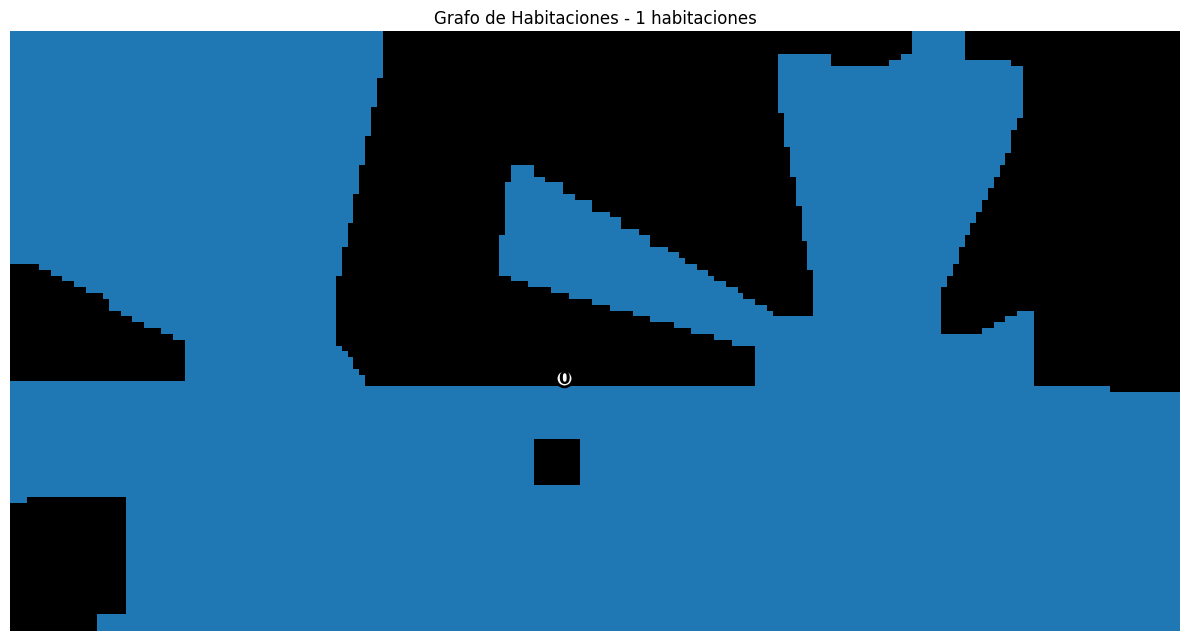

=== Grafo Topológico (Habitaciones) ===

Nodos: 1
Aristas: 0

Nodos:
  Nodo 0: pos=(4.73, 2.96)m, vecinos=[]

Conexiones:


Grafo guardado en 'grafo_mapa.pkl'


TypeError: Object of type ndarray is not JSON serializable

In [17]:
# Crear extractor para mapa PGM de ROS
# El archivo YAML de ROS tiene la resolución, léelo o pásala manualmente
extractor = TopologicalGraphExtractor(
    "./maps/mapa_practica3.pgm", 
    resolution=0.05,  # Lee esto del YAML
    occupied_thresh=0.65,  # Ajusta según tu mapa
    free_thresh=0.25
)


print("=== Analizando mapa PGM ===")
print(f"Dimensiones: {extractor.img.shape}")
print(f"Rango valores: {extractor.img.min()}-{extractor.img.max()}")
print(f"Espacio libre: {np.sum(extractor.binary == 255)} píxeles")
print(f"Espacio ocupado: {np.sum(extractor.binary == 0)} píxeles\n")

# Método recomendado para ROS: Habitaciones
print("Extrayendo grafo de habitaciones...")
G = extractor.method_room_segmentation(visualize=True)

# Exportar para LLM
texto_llm = extractor.export_to_text(G, "Habitaciones")
print(texto_llm)

# Guardar grafo (varias opciones)

# Opción 1: Pickle estándar (recomendado)
import pickle
with open("grafo_mapa.pkl", "wb") as f:
    pickle.dump(G, f)
print("\nGrafo guardado en 'grafo_mapa.pkl'")

# Opción 2: JSON (más portable, legible)
from networkx.readwrite import json_graph
import json
data = json_graph.node_link_data(G)
with open("grafo_mapa.json", "w") as f:
    json.dump(data, f, indent=2)
print("Grafo guardado en 'grafo_mapa.json'")

# Opción 3: GraphML (estándar XML, compatible con otros tools)
nx.write_graphml(G, "grafo_mapa.graphml")
print("Grafo guardado en 'grafo_mapa.graphml'")

In [3]:
pip install scikit-image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 25.3 MB/s  0:00:00eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [scikit-image] [scikit-image]
Note: you may need to restart the kernel to use updated packages.


In [6]:
ls maps

input.json          mapa_practica2.yaml  map.pgm       rosgraph.svg
llm_current.json    mapa_practica3.pgm   map.yaml      watch_llm.sh*
mapa_practica2.pgm  mapa_practica3.yaml  rosgraph.png


In [10]:
import numpy as np
import cv2
from skimage.morphology import skeletonize

# 1) Cargar PGM (OpenCV lo lee como grayscale)
img = cv2.imread("./maps/mapa_practica2.pgm", cv2.IMREAD_GRAYSCALE)

# 2) Binarizar
# Convención típica de mapas ROS en PGM: negro = obstáculo, blanco = libre (gris = unknown en algunos mapas)
# Ajusta el umbral según tu PGM
free = img > 200          # libre
obst = img < 50           # obstáculo

# Si tienes unknown (gris), decide: tratarlo como obstáculo para ser conservador
unknown = (~free) & (~obst)
obstacles = obst | unknown

free_mask = (~obstacles).astype(np.uint8) * 255  # no-cero=free, cero=obstacle

# 3) Distance transform (distancia al obstáculo más cercano)
dist = cv2.distanceTransform(free_mask, cv2.DIST_L2, cv2.DIST_MASK_PRECISE)

# 4) Esqueleto (proxy GVD)
skel = skeletonize(free_mask.astype(bool))

# 5) Exportar un overlay simple
gvd_img = np.zeros_like(img, dtype=np.uint8)
gvd_img[skel] = 255
cv2.imwrite("gvd_skeleton.pgm", gvd_img)


True